In [1]:
import sys, os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import pydicom
from pydicom.data import get_testdata_files

## Image Loading

Façamos o carregamento das imagens do treino e teste a serem utilizadas na análise dos dados.

In [2]:
# --- Loading images ---
filenames = []
train_imgs = []
test_imgs = []
for filename in os.listdir("train_images"):
    filenames.append( filename.replace("-c.dcm", "").replace(".dmc","") )
    train_imgs.append( pydicom.dcmread("train_images/"+filename).pixel_array )
for filename in os.listdir("test_images"):
    test_imgs.append( pydicom.dcmread("test_images/"+filename).pixel_array )
train_imgs = np.array(train_imgs)
test_imgs = np.array(test_imgs)

# --- Get train image labels ---
train_labels = pd.read_csv("train.csv")
keys = list(train_labels.iloc[:,0])
values = np.array([name.split()[0] for name in list(train_labels.iloc[:,1])]).astype(int)
file_to_class = dict(zip(keys, values))
labels_codes = np.array([file_to_class.get(filename) for filename in filenames])

bodyparts = {0:'Abdomen', 1:'Ankle', 2:'Cervical Spine', 3:'Chest', 4:'Clavicles', 5:'Elbow',
             6:'Feet' ,7 : 'Finger' ,8 : 'Forearm' ,9 : 'Hand' ,10 : 'Hip' ,11 : 'Knee',
             12: 'Lower Leg', 13 : 'Lumbar Spine' ,14 : 'Others' ,15 :'Pelvis',16 :'Shoulder',
             17:'Sinus', 18:'Skull', 19 : 'Thigh' ,20 :'Thoracic Spine',21: 'Wrist'}
label_names = np.array([bodyparts[label] for label in labels_codes])

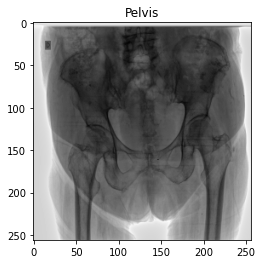

In [3]:
j = 1
plt.imshow(train_imgs[j], cmap = "gray")
plt.title(label_names[j])
plt.show()

In [4]:
def normalize(img, a = 0, b = 255):
    img = img.astype(float)
    
    imax = np.max(img)
    imin = np.min(img)
    
    if(imin == imax):
        np.ones(shape = img.shape) * a
    
    img = (img - imin) / (imax - imin) * b
    return img

def sliced_gray(I, A, B, L, method = 0, plot = True):
    '''
        method = 0 : Original
        method = 1 : Binário
        method = 2 : Identity
        method = 3 : Negative
    '''
    img = I.copy()
    if(method == 0):
        return img
    elif(method == 1):
        img[(I >= A) & (I <= B)] = 255
        img[(I < A) | (I > B)] = 0
    elif(method == 2):
        img[(I >= A) & (I <= B)] = L
    elif(method == 3):
        img[(I >= A) & (I <= B)] = L
        img[(I < A) | (I > B)] = 255 - img[(I < A) | (I > B)]
    
    if(plot):
        x = np.arange(np.min(I), np.max(I), 1)
        y = x.copy()
        if(method == 1):
            y[(x >= A) & (x <= B)] = 255
            y[(x < A) | (x > B)] = 0
        elif(method == 2):
            y[(x >= A) & (x <= B)] = L
        elif(method == 3):
            y[(x >= A) & (x <= B)] = L
            y[(x < A) | (x > B)] = 255 - y[(x < A) | (x > B)]
        plt.plot(x,y)
        plt.show()
    
    return img

In [5]:
# --- Normalize all images ---
train_imgs = np.array([normalize(train_imgs[j]).astype(np.uint8) for j in range(train_imgs.shape[0])])
test_imgs = np.array([normalize(test_imgs[j]).astype(np.uint8) for j in range(test_imgs.shape[0])])

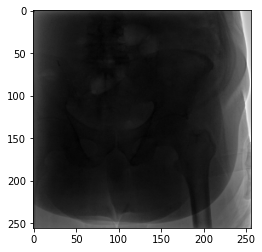

In [6]:
img = sliced_gray(train_imgs[0], 75, 150, 10, method = 0, plot = False)
plt.imshow(img, cmap="gray")
plt.show()

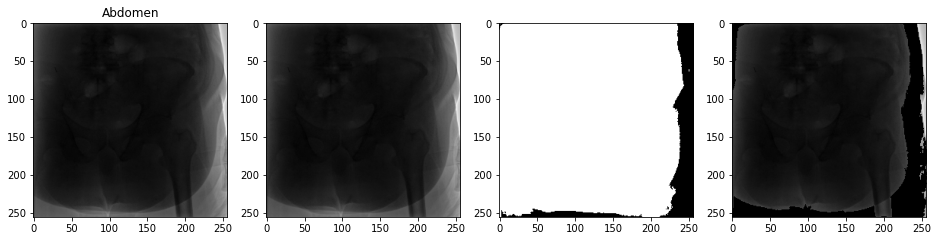

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (16,4))

j = 0
img = train_imgs[j]
binary_img = sliced_gray(img, 75, 150, 255, method = 0, plot = False)
slice_img = sliced_gray(img, 0, 90, 0, method = 1, plot = False)
negative_img = sliced_gray(img, 70, 150, 0, method = 2, plot = False)

ax[0].imshow(img, cmap = "gray")
ax[0].set_title(label_names[j])
ax[1].imshow(binary_img, cmap = "gray")
ax[2].imshow(slice_img, cmap = "gray")
ax[3].imshow(negative_img, cmap = "gray")
plt.show()

## Bag of Features

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from imageio import imread
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from skimage import feature

import pydicom
from pydicom.dataset import Dataset, FileDataset, FileMetaDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids
from pydicom.uid import UID

import SimpleITK as sitk  

In [9]:
class LBP:
    def __init__(self,
                 random_state = 1,
                 patch_size = (11,11), n_patches = 250, # patches
                 lbp_radius = 2, lbp_sampling_pixels = 8, # lbp
                 n_dic = 50, 
                ):
        self.random_state = random_state
        self.patch_size = patch_size
        self.n_patches = n_patches
        self.lbp_radius = lbp_radius
        self.lbp_sampling_pixels = lbp_sampling_pixels
        self.n_dic = n_dic
        pass
        
    
    @staticmethod
    def _get_patches(image, random_state, patch_size, n_patches):
        img = normalize( image ).astype(np.uint8)
        
        # Extract subimages
        patch = extract_patches_2d(img,
                                   patch_size=patch_size,
                                   max_patches=n_patches, 
                                   random_state=random_state)

        if(len(img.shape) == 3):
            reshaped_patch = patch.reshape((n_patches, np.prod( patch_size ) * img.shape[2] ))
        else:
            reshaped_patch = patch.reshape((n_patches, np.prod( patch_size ) ))

        return reshaped_patch
    
    @staticmethod
    def _lbp_features(img, radius=1, sampling_pixels=8):
        
        # LBP operates in single channel images so if RGB images are provided     
        # we have to convert it to grayscale
        if (len(img.shape) > 2):
            img = img.astype(float)
            # RGB to grayscale convertion using Luminance
            img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

        # converting to uint8 type for 256 graylevels
        img = img.astype(np.uint8)

        # normalize values can also help improving description
        i_min = np.min(img)
        i_max = np.max(img)
        if (i_max - i_min != 0):
            img = (img - i_min)/(i_max-i_min)

        # compute LBP
        lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")

        # LBP returns a matrix with the codes, so we compute the histogram
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

        # normalization
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        # return the histogram of Local Binary Patterns
        return hist
    
    def get_patches(self, images):
        self.images = images
        self.n_imgs = len(images)
        patch_arr = Parallel(n_jobs=-1)(delayed(LBP._get_patches)(
            image, 
            self.random_state,
            self.patch_size,
            self.n_patches) for image in images)
        self.patch_arr = np.array(patch_arr)
    
    def fit(self):
        total_patches = self.patch_arr.reshape((self.patch_arr.shape[0] * self.patch_arr.shape[1], self.patch_size[0],
                                                self.patch_size[0]))

        # --- Obtaining features lbp for each patch ---
        patch_lbp = []
        for pat in total_patches:
            f = LBP._lbp_features(pat, self.lbp_radius, self.lbp_sampling_pixels)
            patch_lbp.append(f)
        self.patch_lbp = np.array(patch_lbp)
        
        # --- Learning dictionary ---
        
        # Define a KMeans clustering model
        self.kmeans_model = KMeans(n_clusters=self.n_dic, 
                              verbose=False, 
                              init='random',
                              random_state=self.random_state, 
                              n_init=3)
        # fit the model
        self.kmeans_model.fit(patch_lbp)
        
        # --- Histograms of Bag of Features ---
        
        # compute features for each image
        img_feats = []
        for i in range(self.n_imgs):
            # predicting n_patches of an image
            y = self.kmeans_model.predict(patch_lbp[(i*self.n_patches):(i*self.n_patches+self.n_patches)])

            # computes histogram and append in the array
            hist_bof,_ = np.histogram(y, bins=range(self.n_dic+1), density=True)
            img_feats.append(hist_bof)

        self.img_feats = np.array(img_feats, copy=False)
    
    def recognition(self, queryImage, queryIndex):
        # get query patches
        query_patches = np.array( LBP._get_patches(queryImage, self.random_state, self.patch_size, self.n_patches) )

        query_patches = query_patches.reshape((query_patches.shape[0],
                                       self.patch_size[0],self.patch_size[0]))

        # print('Extracted patches')
        # print(query_patches.shape)

        # get LBP feathres
        query_lbp = []
        for pat in query_patches:
                f = LBP._lbp_features(pat, self.lbp_radius, self.lbp_sampling_pixels)
                query_lbp.append(f)

        query_lbp = np.array(query_lbp, copy=False)
        # print('LBP extractd')
        # print(query_lbp.shape)

        # get visual words for query
        y = self.kmeans_model.predict(query_lbp)
        # computes descriptor
        query_feats,_ = np.histogram(y, bins=range(self.n_dic+1), density=True)

        # computes distances
        dists = []
        for i in range(self.n_imgs):
            diq = np.sqrt(np.sum( (self.img_feats[i] - query_feats)**2 ))
            dists.append(diq)

        # check the nearest images
        k = 8
        k_cbir = np.argsort(dists)[:k]

        plt.figure(figsize=(12,8))
        plt.subplot(331); plt.imshow(test_imgs[queryIndex], cmap="gray")
        plt.title('Query'); plt.axis('off')

        imgs = []
        for i in range(k):
            imgs.append(train_imgs[k_cbir[i]])
            plt.subplot(3,3,i+2); plt.imshow(imgs[i], cmap="gray")
            plt.title('%d, %.4f' % (i, dists[k_cbir[i]])); plt.axis('off')
            
        pass 


In [10]:
#sliced_gray(I, A, B, L, method = 0, plot = True)
A = 100
B = 200
L = 255

# --- Method 1 - Binary ---
binary_train_imgs = np.array([sliced_gray(train_imgs[j], A, B, L, method = 1, plot = False).astype(np.uint8) for j in range(train_imgs.shape[0])])
binary_test_imgs = np.array([sliced_gray(test_imgs[j], A, B, L, method = 1, plot = False).astype(np.uint8) for j in range(test_imgs.shape[0])])

# --- Method 2 - Identity ---
identity_train_imgs = np.array([sliced_gray(train_imgs[j], A, B, L, method = 2, plot = False).astype(np.uint8) for j in range(train_imgs.shape[0])])
identity_test_imgs = np.array([sliced_gray(test_imgs[j], A, B, L, method = 2, plot = False).astype(np.uint8) for j in range(test_imgs.shape[0])])

# --- Method 3 - Negative ---
negative_train_imgs = np.array([sliced_gray(train_imgs[j], A, B, L, method = 3, plot = False).astype(np.uint8) for j in range(train_imgs.shape[0])])
negative_test_imgs = np.array([sliced_gray(test_imgs[j], A, B, L, method = 3, plot = False).astype(np.uint8) for j in range(test_imgs.shape[0])])

In [11]:
lbp_params = {"random_state" : 4,
    "patch_size" : (15,15),
    "n_patches": 250,
    "lbp_radius":2,
    "lbp_sampling_pixels" : 8,
    "n_dic" : 100}

# LBP - Original
lbp_original = LBP(**lbp_params)
lbp_original.get_patches(train_imgs)
lbp_original.fit()

# LBP - Binary
lbp_binary = LBP(**lbp_params)
lbp_binary.get_patches(binary_train_imgs)
lbp_binary.fit()

# LBP - Identity
lbp_identity = LBP(**lbp_params)
lbp_identity.get_patches(identity_train_imgs)
lbp_identity.fit()

# LBP - Negative
lbp_negative = LBP(**lbp_params)
lbp_negative.get_patches(negative_train_imgs)
lbp_negative.fit()

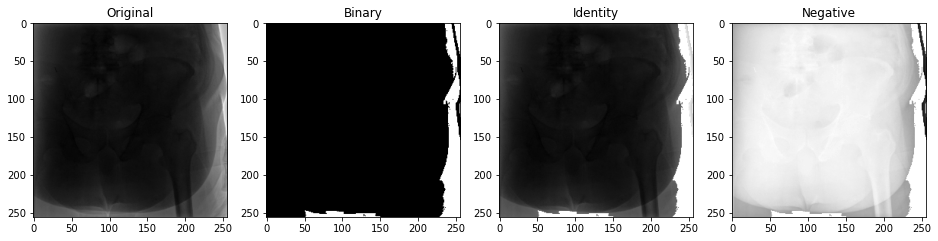

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (16,4))

j = 0
img = train_imgs[j]
binary_img = binary_train_imgs[j]
identity_img = identity_train_imgs[j]
negative_img = negative_train_imgs[j]

ax[0].imshow(img, cmap = "gray")
ax[0].set_title("Original")
ax[1].imshow(binary_img, cmap = "gray")
ax[1].set_title("Binary")
ax[2].imshow(identity_img, cmap = "gray")
ax[2].set_title("Identity")
ax[3].imshow(negative_img, cmap = "gray")
ax[3].set_title("Negative")
plt.show()

In [13]:
def recognition_method(queryIndex, method = 0, plot = False):
    dic = {0:"Original", 1:"Binary", 2:"Identity", 3:"Negative"}
    print("Método: {}".format(dic[method]))
    
    if method == 0: 
        imgQuery = test_imgs[queryIndex]
        lbp_original.recognition(imgQuery, queryIndex)
        
        
    elif method == 1: 
        imgQuery = binary_test_imgs[queryIndex]
        lbp_binary.recognition(imgQuery, queryIndex)
        
    elif method == 2: 
        imgQuery = identity_test_imgs[queryIndex]
        lbp_identity.recognition(imgQuery, queryIndex)
        
    elif method == 3: 
        imgQuery = negative_test_imgs[queryIndex]
        lbp_negative.recognition(imgQuery, queryIndex)

    


Método: Negative


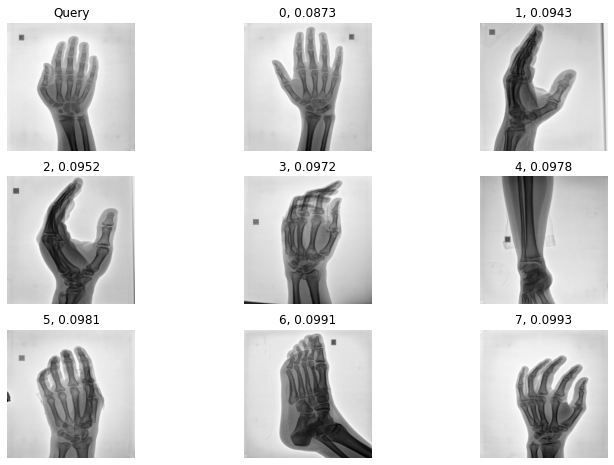

In [14]:
recognition_method(0, method = 3)

# Muda as imagens de DCM para JPG

In [15]:

from matplotlib import pyplot as plt

#Treino
#for path in ["train_images/"+path for path in os.listdir("train_images")][:1]:
#    img=pydicom.dcmread(path, force = True).pixel_array
#    plt.imsave("train_images_jpg/"+path[13:-4]+".jpg", img, cmap = "gray")

#Teste
#for path in ["test_images/"+path for path in os.listdir("test_images")]:
#    img=pydicom.dcmread(path, force = True).pixel_array
#    plt.imsave("test_images_jpg/"+path[12:-4]+".jpg", img, cmap = "gray")
    
#Não sei pq, mas o jpg salva as imagens como tendo cor...

In [16]:
#for path in ["train_images_jpg/"+path for path in os.listdir("train_images_jpg")][:1]:
#    img=(plt.imread(path))[:,:,0]
    #img = img[:,:,0]
#    plt.imshow(img)
#    print(img)
#    print(img.shape)